# Isotherm conversion and selection

This notebook will perform the following:

- convert all isotherms in a pyGAPS format
- perform a selection based on comparable isotherms on common probes. 
- consolidate isotherms into a SQLite database. 

Run this notebook with ``./notebooks`` as the root directory.

In [1]:
import warnings
import pickle
import json
from collections import Counter
from tqdm import tqdm
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygaps

basedir = pathlib.Path.cwd().parent / "data"
with open(basedir / "isotherms.pickle", 'rb') as f:
    isos = pickle.load(f)
print(f"Loaded {len(isos)} full isotherms.")

Loaded 32553 full isotherms.


## Conversion of NIST isotherms into pyGAPS isotherms
In converting to pyGAPS isotherms, many of the isotherms will be automatically screened:
 - Multicomponent isotherms will be automatically removed, as they are not the focus of this study.
 - Isotherms with units which are not standard (*molecules/u.c* or *mol/m2*) are removed


In [2]:
pygaps_isos = []
pygaps_errs = []

for iso in tqdm(isos):
    try:
        pygaps_isos.append(pygaps.isotherm_from_json(json.dumps(iso), fmt="NIST"))
    except Exception as e:
        pygaps_errs.append((str(e), iso))

failed_summary = Counter([err[0] for err in pygaps_errs])
print(f"There were {len(pygaps_isos)} successful conversions out of {len(isos)} isotherms.")
print(f"Conversion failed because {failed_summary}")

0%|          | 31/32553 [00:00<01:48, 301.01it/s]c:\users\pauli\git\pygaps\src\pygaps\core\isotherm.py:122: UserWarning: Specified adsorbent is not in internal list (or name cannot be resolved to an existing one). CoolProp backend disabled for this adsorbent.
  ("Specified adsorbent is not in internal list "
100%|██████████| 32553/32553 [01:14<00:00, 435.08it/s]There were 25317 successful conversions out of 32553 isotherms.
Conversion failed because Counter({'Isotherm cannot be parsed due to loading string format.': 3702, 'Isotherm cannot be parsed due to loading unit.': 2482, 'Cannot currently read multicomponent isotherms': 758, 'Isotherm cannot be parsed due to adsorbent basis.': 294})



Afterwards, more sorting is performed:
  - The number of adsorbents is reduced to only adsorbents which can be processed by the thermodynamic properties backend (CoolProp)
  - Units which cannot be converted to *mmol/g* without further information, such as volumetric units (density of the adsorbent is required) are removed.

In [3]:
ads_isos = [iso for iso in pygaps_isos if iso.adsorbate in pygaps.ADSORBATE_LIST]
print(f"There were {len(ads_isos)} selected isotherms out of {len(pygaps_isos)} isotherms.")

There were 24670 selected isotherms out of 25317 isotherms.


In [4]:
unit_isos = [iso for iso in ads_isos if iso.adsorbent_basis == 'mass']
print(f"There were {len(unit_isos)} selected isotherms out of {len(ads_isos)} isotherms.")

There were 23094 selected isotherms out of 24670 isotherms.


Then, all isotherms are coverted to a single type of unit, in this case *mmol/g*, to allow comparisons. Isotherms in *ml* loading unit are similarly removed, as it is unsure if it is meant *ml of gas at STP*, *ml of gas at isotherm T* or *ml of liquid*.

In [5]:
counter = Counter([iso.pressure_unit for iso in unit_isos])
print(f"Types of pressure units: {counter}")
counter = Counter([iso.pressure_mode for iso in unit_isos])
print(f"Types of pressure modes: {counter}")
counter = Counter([iso.loading_unit for iso in unit_isos])
print(f"Types of loading units: {counter}")
counter = Counter([iso.loading_basis for iso in unit_isos])
print(f"Types of loading bases: {counter}")
counter = Counter([iso.adsorbent_unit for iso in unit_isos])
print(f"Types of adsorbent units: {counter}")
counter = Counter([iso.adsorbent_basis for iso in unit_isos])
print(f"Types of adsorbent bases: {counter}")

for iso in tqdm(unit_isos):
    if iso.loading_unit == 'ml':
        continue
    iso.convert_loading(basis_to='molar', unit_to='mmol')
    iso.convert_adsorbent(basis_to='mass', unit_to='g')

3%|▎         | 609/23094 [00:00<00:03, 6053.13it/s]Types of pressure units: Counter({'bar': 23094})
Types of pressure modes: Counter({'absolute': 23094})
Types of loading units: Counter({'mmol': 12740, 'cm3(STP)': 8536, 'mg': 917, 'ml': 485, 'g': 293, 'mol': 123})
Types of loading bases: Counter({'molar': 21884, 'mass': 1210})
Types of adsorbent units: Counter({'g': 23058, 'kg': 36})
Types of adsorbent bases: Counter({'mass': 23094})
  9%|▉         | 2031/23094 [00:00<00:05, 3902.71it/s]c:\users\pauli\git\pygaps\src\pygaps\core\adsorbate.py:303: UserWarning: Adsorbate 1-butanol does not have a property named backend_name. This must be available for CoolProp interaction
  warnings.warn(str(e_info))
c:\users\pauli\git\pygaps\src\pygaps\core\adsorbate.py:304: UserWarning: Attempting to read dictionary
  warnings.warn('Attempting to read dictionary')
c:\users\pauli\git\pygaps\src\pygaps\core\adsorbate.py:303: UserWarning: 'NoneType' object has no attribute 'molar_mass'
  warnings.warn(str(

## Removal of unphysical isotherms

The selection process of isotherms in the ISODB may result in erroneous isotherms, thus, we need to remove datapoints which can be rationally deemed "impossible", as well as isotherms which do not have enough points for further processing. This is necessarily biassed towards what the author considers reliable data.

Here, we have selected isotherms which have:

- At least 5 measurement points.
- A **temperature less than 423 K** (150 C). It is unlikely that isotherms are measured above this temperature.
- **Points at positive pressures**. While a margin of error exists, the maximum recorded point should be positive.
- A **realistic maximum pressure**. Few isotherms are recorded up to GPa ranges, so 500 bar is a good limit to remove outliers.
- At least **one positive loading point**: it could be expected that due to measurement errors and low uptakes, initial loading points could be negative. However, isotherms with no uptake point larger than 0 are considered unsuitable.
- A **realistic maximum loading**. To clearly quantify whether there is an error in reporting maximum uptake, comparing 
  volumetric capacity to adsorbate molar density is required. However, as volumetric capacity cannot be calculated without 
  material density, we resort to a (admitedly arbitrary) limit of **1000 mmol/g**.
- Have the NIST parameter 'compositionType' set to 'molefraction' or 'moleratio'. Composition types such as 'volumefraction' or      
  'concentration' represent unknowns.


In [6]:
filtered_isos = [i for i in unit_isos if len(i.loading()) > 5]
print(f'Isotherms with enough points: {len(filtered_isos)}')

filtered_isos = [i for i in filtered_isos if i.temperature < 423.15]
print(f'After removing high temperature isotherms: {len(filtered_isos)}')

filtered_isos = [i for i in filtered_isos if 0 < max(i.pressure()) < 500]
print(f'After removing odd pressure isotherms: {len(filtered_isos)}')

filtered_isos = [i for i in filtered_isos if 0 < max(i.loading()) < 1000]
print(f'After removing odd loading isotherms: {len(filtered_isos)}')

filtered_isos = [i for i in filtered_isos if i.compositionType in ['molefraction', 'moleratio']]
print(f'After removing odd composition isotherms: {len(filtered_isos)}')

print(f'Sorting has removed {len(unit_isos) - len(filtered_isos)} isotherms')

Isotherms with enough points: 22544
After removing high temperature isotherms: 22357
After removing odd pressure isotherms: 22161
After removing odd loading isotherms: 22116
After removing odd composition isotherms: 22071
Sorting has removed 1023 isotherms


A sorting based on maximum pressure limits can also be performed. To this end, we can classify the isotherms into the following categories:

- Supercritical isotherms. High pressures are often common with such isotherms.
- Subcritical isotherms. The maximum pressure achievable with a subcritical adsorbate is the vapour pressure of that adsorbate at the isotherm temperature. Any isotherm with a pressure point larger than **1.1 times p0** (to account for slight error points) is removed.
- Low temperature isotherms (subcooled), where the vapour pressure cannot be easily calculated due to the solid phase being standard at this point.

In [7]:
for iso in filtered_isos:
    try:
        ads = iso.adsorbate.backend

    except Exception as e:
        iso.tempRange = 'unknown'
        print(e)
        continue

    if ads is None:
        iso.tempRange = 'unknown'
        continue
    
    if ads.Tmin() > iso.temperature:
        iso.tempRange = 'subcooled'
        continue
        
    if iso.temperature > ads.T_critical():
        iso.tempRange = 'supercritical'
        continue

    iso.tempRange = 'subcritical'

counter = Counter([iso.tempRange for iso in filtered_isos])
print(f"Types of isotherms by temperature range: {counter}")

Adsorbate 1-propanol does not have a property named backend_name. This must be available for CoolProp interaction
Adsorbate 2-propanol does not have a property named backend_name. This must be available for CoolProp interaction
Adsorbate nitrogen dioxide does not have a property named backend_name. This must be available for CoolProp interaction
Adsorbate nitric oxide does not have a property named backend_name. This must be available for CoolProp interaction
Adsorbate acetylene does not have a property named backend_name. This must be available for CoolProp interaction
Types of isotherms by temperature range: Counter({'subcritical': 12558, 'supercritical': 8494, 'subcooled': 679, 'unknown': 340})


In [9]:
p_filtered_isos = []

for iso in tqdm(filtered_isos):

    if iso.tempRange == 'subcritical':
        if max(iso.pressure()) > 1.1 * iso.adsorbate.saturation_pressure(iso.temperature, unit='bar'):
            continue

    p_filtered_isos.append(iso)

print(f'Pressure sorting has removed {len(filtered_isos) - len(p_filtered_isos)} isotherms')

100%|██████████| 22071/22071 [00:09<00:00, 2235.64it/s]Pressure sorting has removed 595 isotherms



## Generate required data

Now, for each isotherm, the henry coefficient will be pre-computed. pyGAPS has two methods of determining the Henry coefficient: a virial model fitting procedure and an initial linear slope procedure. As not all isotherms may be described by a virial model, the linear slope method is used. 

In [10]:
errors = []
henry_isos = []

for iso in tqdm(p_filtered_isos):
    try:
        iso.henry_k = pygaps.initial_henry_slope(iso)
        if 1e-7 < iso.henry_k < 1e7 and not np.isnan(iso.henry_k):
            henry_isos.append(iso)
    except Exception as e:
        iso.henry_k = None
        errors.append(iso)

# Only use isotherms which have the henry coefficient (slope mehtod) calculated going forward
print(f'Isotherms with Henry coefficient: {len(henry_isos)} out of {len(p_filtered_isos)}')

100%|██████████| 21476/21476 [33:52<00:00, 10.57it/s]Isotherms with Henry coefficient: 20936 out of 21476



## Overview figure

An overview figure is generated from the now selected isotherms

In [11]:
final_isos = henry_isos

C:\Users\pauli\Miniconda3\envs\dscience\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


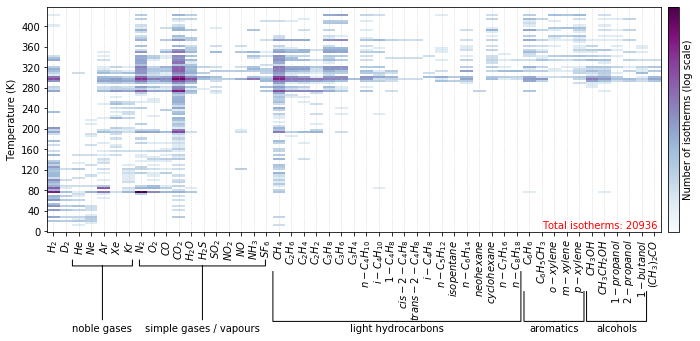

In [12]:
import matplotlib.pyplot as plt
adsorbates = [
    'hydrogen', 'deuterium',

    'helium', 'neon', 'argon', 'xenon', 'krypton',

    'nitrogen', 'oxygen', 'carbon monoxide', 'carbon dioxide', 'water',
    'hydrogen sulfide', 'sulphur dioxide', 'nitrogen dioxide', 'nitric oxide', 'ammonia', 'sulfur hexafluoride',

    'methane', 
    'ethane', 'ethene', 'acetylene',
    'propane', 'propene', 'propyne',
    'butane', 'isobutane',
    '1-butene', 'cis-2-butene', 'trans-2-butene', 'isobutene',
    'n-pentane', 'isopentane', 
    'n-hexane', 'neohexane', 'cyclohexane',
    'n-heptane', 'n-octane',

    'benzene', 'toluene',
    'o-xylene', 'm-xylene', 'p-xylene',
    
    'methanol', 'ethanol', '1-propanol',
    '2-propanol', '1-butanol', 'acetone',
]
isos_by_ads = {ads: [i for i in final_isos if i.adsorbate == ads]
                    for ads in adsorbates}

distribution_temp = {
    ads: np.log10(
        np.histogram([i.temperature for i in isos_by_ads[ads]],
                    bins=110, density=False, range=(0, 440))[0]) for ads in adsorbates}

df = pd.DataFrame(distribution_temp, columns=distribution_temp.keys())
# %%
fig, ax = plt.subplots(1, figsize=(11, 4))
labelsx = list(('$'+pygaps.Adsorbate.find(i).formula+'$')
               for i in distribution_temp)
labelsy = np.arange(0, 110, 10)
plt.yticks(labelsy, labelsy * 4)
plt.xticks(np.arange(len(labelsx)), labelsx, rotation=90, fontsize=10)
res = ax.imshow(df, origin='lower', aspect='auto',
                cmap='BuPu', vmin=-0.5)
cb = fig.colorbar(res, ax=ax, label='Number of isotherms (log scale)',
                  ticks=[], pad=0.01)
plt.grid(True, axis='x', linestyle=':', alpha=0.6)
ax.set_ylabel('Temperature (K)')


x1 = 0.09
x2 = 0.253
x3 = 0.57
x4 = 0.826
x5 = 0.928
y = -0.45

ax.annotate('noble gases', xy=(x1, -0.14), xytext=(x1, y),
            xycoords='axes fraction',
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=0.6', lw=1.0))

ax.annotate('simple gases / vapours', xy=(x2, -0.14), xytext=(x2, y),
            xycoords='axes fraction',
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.6', lw=1.0))

ax.annotate('light hydrocarbons', xy=(x3, -0.395), xytext=(x3, y),
            xycoords='axes fraction',
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=12.4, lengthB=5', lw=1.0))

ax.annotate('aromatics', xy=(x4, -0.395), xytext=(x4, y),
            xycoords='axes fraction',
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3.0, lengthB=3', lw=1.0))

ax.annotate('alcohols', xy=(x5, -0.395), xytext=(x5, y),
            xycoords='axes fraction',
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3.0, lengthB=3', lw=1.0))

ax.text(39, 1, f'Total isotherms: {len(final_isos)}', color='red')

plt.tight_layout()
fig.subplots_adjust(bottom=0.18)
plt.savefig('./nist-dataset.png', bbox_inches="tight", dpi=300)

## Storage of isotherms in a database

Now we store the filtered isotherms in a SQLite database. First the database is created and populated with prerequisites.

In [17]:
from pygaps.utilities.sqlite_db_creator import db_create

db_path = pathlib.Path.cwd().parent / "data" / "iso.db"
db_create(db_path)

pygaps.db_upload_isotherm_data_type(db_path, {'type': 'pressure'})
pygaps.db_upload_isotherm_data_type(db_path, {'type': 'loading'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'iso_ref'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'filename'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'DOI'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'articleSource'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'date'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'digitizer'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'compositionType'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'concentrationUnits'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'tempRange'})
pygaps.db_upload_isotherm_property_type(db_path, {'type': 'henry_k'})
pygaps.db_upload_isotherm_type(db_path, {'type': 'exp'})
pygaps.db_upload_isotherm_type(db_path, {'type': 'sim'})
pygaps.db_upload_isotherm_type(db_path, {'type': 'mod'})
pygaps.db_upload_isotherm_type(db_path, {'type': 'qua'})
pygaps.db_upload_isotherm_type(db_path, {'type': 'unk'})

# Upload adsorbates
for adsorbate in pygaps.ADSORBATE_LIST:
    for prop in adsorbate.to_dict():
        try:
            pygaps.db_upload_adsorbate_property_type(db_path, {'type': prop}, verbose=False)
        except:
            pass
    pygaps.db_upload_adsorbate(db_path, adsorbate, verbose=False)

# Upload materials
materials = Counter((iso.material, iso.material_batch) for iso in final_isos)
for (material, nist_hash) in tqdm(materials.keys()):
    pygaps.db_upload_material(db_path, pygaps.Material(material, nist_hash), verbose=False)


Experiment property type uploaded pressure_mode
Experiment property type uploaded pressure_unit
Experiment property type uploaded adsorbate_mode
Experiment property type uploaded adsorbate_unit
Experiment property type uploaded loading_mode
Experiment property type uploaded loading_unit
Experiment data type uploaded pressure
Experiment data type uploaded loading
Experiment property typeuploaded iso_ref
Experiment property type uploaded filename
Experiment property type uploaded DOI
Experiment property type uploaded articleSource
Experiment property type uploaded date
Experiment property type uploaded digitizer
Experiment property type uploaded compositionType
Experiment property type uploaded concentrationUnits
Experiment property typeuploaded tempRange
Experiment property type uploaded henry_k
Experiment type uploaded exp
Experiment type uploaded sim
Experiment type uploaded mod
Experiment type uploaded qua
Experiment type uploaded unk
100%|██████████| 4411/4411 [01:45<00:00, 41.74it/

Then all isotherms are uploaded one by one.

In [19]:
for iso in tqdm(final_isos):

    if getattr(iso, 'iso_type', None) is None:
        iso.iso_type = 'unk'

    try:
        pygaps.db_upload_isotherm(db_path, iso, verbose=False)
    except Exception as e:
        print(e)
        iso.print_info()
        break

100%|██████████| 20936/20936 [10:22<00:00, 33.65it/s]


## Examples of isotherms which were removed through this filtering

In [ ]:
[iso for iso in pygaps_isos if iso.adsorbate not in pygaps.ADSORBATE_LIST][33].plot(lgd_keys=['adsorbate'], show=False)
plt.savefig('discarded-adsorbate')
[iso for iso in pygaps_isos if iso.adsorbent_basis != 'mass'][0].plot(lgd_keys=['adsorbate'], show=False)
plt.savefig('discarded-basis')
[iso for iso in pygaps_isos if iso.loading_unit == 'ml'][5].plot(lgd_keys=['adsorbate'], show=False)
plt.savefig('discarded-unit')
next(iso for iso in pygaps_isos if len(iso.pressure()) < 5).plot(lgd_keys=['adsorbate'], show=False)
plt.savefig('discarded-points')
[iso for iso in pygaps_isos if iso.temperature > 493.15][9].plot(lgd_keys=['adsorbate', 'temperature'], show=False)
plt.savefig('discarded-temperature')
next(iso for iso in pygaps_isos if max(iso.pressure()) < 500).plot(lgd_keys=['adsorbate'], show=False)
plt.savefig('discarded-pressure')
next(iso for iso in pygaps_isos if max(iso.pressure()) < 0).plot(lgd_keys=['adsorbate'], show=False)
plt.savefig('discarded-pressure-min')
next(iso for iso in pygaps_isos if max(iso.loading()) < 0 and len(iso.loading())> 5).plot(lgd_keys=['adsorbate'], show=False, y1_range=[-2, 1])
plt.savefig('discarded-uptake-min')
[iso for iso in pygaps_isos if max(iso.loading()) > 1000 and iso.loading_unit == 'mmol' and iso.adsorbent_unit == 'g'][3].plot(lgd_keys=['adsorbate'], show=False)
plt.savefig('discarded-uptake-max')
[iso for iso in filtered_isos if iso.tempRange == 'subcritical' and  max(iso.pressure()) > 1.1][11].plot(lgd_keys=['adsorbate', 'temperature'], show=False)
plt.savefig('discarded-pressure-odd')
[iso for iso in p_filtered_isos if iso.henry_k and iso.henry_k > 1e7][5].plot(lgd_keys=['adsorbate', 'temperature'], show=False)
plt.savefig('discarded-henry-odd')